<h2><center>ASSIGNMENT 3</center></h2>
<h2><center>DEEP ASHISH JARIWALA, JAYDEEP SINGH</center></h2>
<h2><center>GROUP - 31</center></h2>
<h2><center>Q: CM2</center></h2>

### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

### IMPORTING THE DATASET

In [2]:
from datasets import load_dataset
dataset = load_dataset('climate_fever')

Using custom data configuration default
Reusing dataset climate_fever (C:\Users\DEEP\.cache\huggingface\datasets\climate_fever\default\1.0.1\3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [3]:
dataset['test']

Dataset({
    features: ['claim_id', 'claim', 'claim_label', 'evidences'],
    num_rows: 1535
})

Observing the dataset, we see that the dataset is in the form of a dictionary and we will use claim and evidences as features to train our data, since these include sentences which can be used to train our model to generate word embeddings. 

### CONSTRUCTING CORPUS --- ALL SENTENCES IN THE DATASET

In [4]:
corpus = []
for item in dataset['test']:
    corpus.append(item['claim'])
    for evidence in item['evidences']:
        corpus.append(evidence['evidence'])

### TEXT PREPROCESSING USING NLTK

<p>As part of data preprocessing, following tasks are performed:<p>
<ul>
            <li>Tokenisation of the dataset</li>
            <li>Conversion to lowercase</li>
            <li>Removal of stopwords</li>
            <li>Removing punctuations, numbers and special characters</li>
            <li>Lemmatization</li>
            <li>Stemming</li>
</ul>

<p>Details of the preprocessing steps performed on the dataset:<p>
<ul>
            <li>As part of tokenization, we will split longer strings into texts of smaller tokens. Further processing will be done on the text only after it has been appropriately tokenized. Note that the input to word2vec will be a list of tokenized sentences, so that the context of each word when used in a sentence is preserved.</li>
            <li>We are converting all the data to lowercase do that same words are not treated differently because of difference in cases.This is neceassary so that words 'Earth' and 'earth' have same meaning but when not converted to lowercase, these would be treated as two different words in vector space.</li>
            <li>After that we need to remove stop words, these are the words which don't add any additional value to the document.Here we are using nltk library to download all the stop words in english language and then we filter our corpus so that it does not include these stop words.</li>
    <li>Numbers are generally converted to words when they contain a very useful information about the data for example in banking/financial data. Our data contains information about climate , where numbers are not adding any additional information to the data. So in this case, we are removing the numbers.</li>
<li>All the punctuation, numbers and special characters are removed from the corpus, as these are unnecesarry symbols and do not contain any additional information about the data. All these characters will only create unnecessary vectors in the vector space.</li>
            <li>Lemmatization reduces the words present in different forms to their base form which is also a meaningful dictionary word. It is necessary to reduce the text ambiguity. Here, we are using WordNet lemmatizer from the nltk library to lemmatize the text. </li>
            <li>Stemming is a text-normalisation technique that removes the prefix and affix from the words. For example words like "wait", "waiting", "waited", "waits" are reduced to "wait". We are using PorterStemmer in the nltk library to stem the tokens in the corpus. It is necessary as it reduces the converts different variations of the same word to a same form.</li>
</ul>

In [5]:
# TOKENIZING CORPUS TO PREPARE FOR Word2Vec EMBEDDING
from nltk.tokenize import word_tokenize
words_corpus = [word_tokenize(sentence) for sentence in corpus]

# TO REMOVE STOPWORDS
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
fil_list = []
for sentence_list in words_corpus:
    lower_case_sentence = [word.lower() for word in sentence_list]
    fil_list.append(list(filter(lambda x: x not in stop_words,lower_case_sentence)))

# LOWER CASE THE TEXT, REMOVING SPECIAL CHARACTERS AND INTEGERS
import re
final_corpus = []
for sentence_list in fil_list:
    final_corpus.append(list(filter(lambda x: not bool(re.match('[^a-zA-Z]',x)), sentence_list)))

# LEMMATING    
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
final_corpus_lem = []
for sentence_list in final_corpus:
    final_corpus_lem.append(list(filter(lambda x: lemma.lemmatize(x),sentence_list)))

# STEMMING
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
final_corpus_stem = []
for sentence_list in final_corpus_lem:
    final_corpus_stem.append(list(filter(lambda x: stemmer.stem(x),sentence_list)))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DEEP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DEEP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### TRAIN TEST SPLITING

<p>After all the data preprocessing steps are complete, we split our data into train and test sets. An important point to note here is that word2vec needs the context of the words to generate correct embeddings. Thus we keep the context of the words same as in the input data and perform the split on the basis of the sentences in the input data. We split our data such that the train data contains 80% of the sentences and test set contains 20% of the sentences. (The total number of words will be different in both the sets as length of sentences may vary). The purpose of splitting the dataset is check the difference in embedding when the dimensions of Word2Vec embeddings are reduced using dimensionality reduction techniques (PCA in this case).</p>

In [6]:
from sklearn.model_selection import train_test_split
train_corpus, test_corpus = train_test_split(final_corpus_stem, test_size = 0.2, random_state = 0)

### TRAINING THE MODEL USING Word2Vec

<p>The entire dataset is trained using Word2Vec model at default parameters from gensim library.</p>

In [7]:
from gensim.models import Word2Vec
model = Word2Vec(final_corpus_stem, workers = 1)

### SEPERATE TRAIN SET AND TEST SET EMBEDDINGS FROM TRAINED MODEL

<p>This process involves two steps:<p>
<ul>
            <li>The splitted part of  dataset (train and test set) are converted to a flat list.</li>
            <li>Using the vocab of the trained model embeddings for both test set and train set are extracted for dimensionality reduction using PCA</li>
</ul>

In [8]:
# FLATTENING A LIST OF LIST STRUCTURE
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

flat_test = flatten_list(test_corpus)
flat_train = flatten_list(train_corpus)

def getList(dict): 
    return list(dict.keys()) 
       
list_final = getList(model.wv.vocab)

# TRAIN SET EMBEDDINGS
common_train = []
for i in range(len(flat_train)):
    for j in range(len(list_final)):
        if flat_train[i] == list_final[j]:
            common_train.append(flat_train[i])
            
X = model[common_train]

C:\Users\DEEP\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [9]:
# TEST SET EMBEDDINGS
common_test = []
for i in range(len(flat_test)):
    for j in range(len(list_final)):
        if flat_test[i] == list_final[j]:
            common_test.append(flat_test[i])

common_test = set(common_test)
Y = model[common_test]

C:\Users\DEEP\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### PART 1 : PCA ON EMBEDDINGS

<p>Principal component anaylsis is applied on the embeddings to check the number of principal components required to represent maximum variance of the data:<p>
<ul>
            <li>PCA is trained using the embedding of training set (denoted by X in our case) using fit_transform.</li>
            <li>trained model is applied to test set (denoted by Y in our case) embeddings using transform method.</li>
            <li>Scree plot is used as a decision tool to finalize the number of components to be used.</li>
</ul>

In [10]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA()
Principal_components_trained=pca.fit_transform(X)
Principal_components_test=pca.transform(Y)

### Part 2 : SCREE PLOT

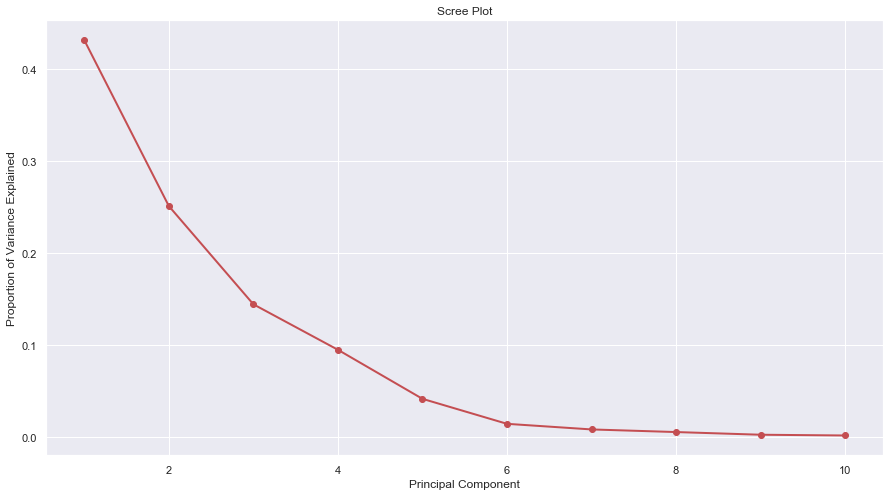

In [11]:
fig = plt.figure(figsize=(15,8))
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

PC_values = np.arange(10) + 1
plt.plot(PC_values, pca.explained_variance_ratio_[:10], 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

<p>Scree plot in PCA serves as a diagnostic tool to check whether PCA works well on the data or not. The number of PCA components are created in order of the amount of variation covered. The plot clearly shows that PC1 captures the maximum variation, PC2 the second most, and so on. It can be seen that just PC1 and PC2 are enough to cover the description of the data as more than 70% proportion of variance is covered. Therefore, number of principal components selected are 2, which best represents the data.</p>

### Part 3 : VISUALIZATION OF FIRST 4 DIMENSIONS OF PCA USING PAIR PLOT

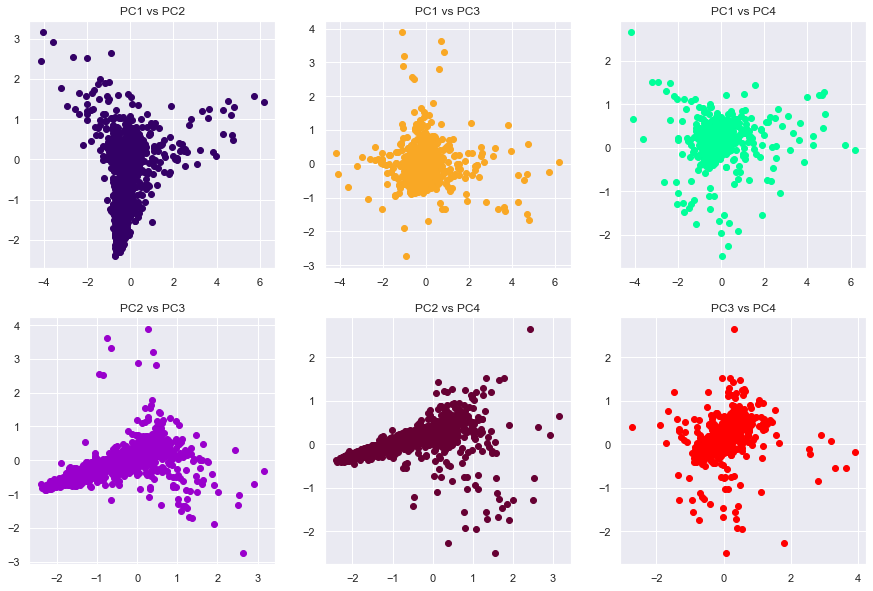

In [12]:
data_pca = pd.DataFrame(Principal_components_test)
data_pca_final = data_pca.iloc[:,[0,1,2,3]]

fig = plt.figure(figsize=(15,10))

plt.subplot(231)
plt.title("PC1 vs PC2")
plt.scatter(x=data_pca_final[0], y=data_pca_final[1], c = '#330066')

plt.subplot(232)
plt.title("PC1 vs PC3")
plt.scatter(x=data_pca_final[0], y=data_pca_final[2], c = '#F9A825')

plt.subplot(233)
plt.title("PC1 vs PC4")
plt.scatter(x=data_pca_final[0], y=data_pca_final[3], c = '#00FF99')

plt.subplot(234)
plt.title("PC2 vs PC3")
plt.scatter(x=data_pca_final[1], y=data_pca_final[2], c = '#9900CC')

plt.subplot(235)
plt.title("PC2 vs PC4")
plt.scatter(x=data_pca_final[1], y=data_pca_final[3], c = '#660033')

plt.subplot(236)
plt.title("PC3 vs PC4")
plt.scatter(x=data_pca_final[2], y=data_pca_final[3], c = 'red')

<p> The above figure represents score plots of our embeddings. These score plots indicate the projection of the data onto the span of principal components. The score plots can be used to access the data structure, detect clusters, outliers and trends. We notice the following observations from the score plots:</p>
<ul>
<li>The graph between PC1 and PC2 represents maximum percentage of variation in the data.</li>
    <li>Correlation can be interpreted by comparing the location of 2 points on the plot. Points lying very close to each other on the plot represent positive correlation(high similarity) whereas if two points lie in diagonally opposite quadrants, it describes negative correlation. </li>
    <li>The score plots help us in identifying the outliers/exterme observations in the dataset. The points lying far away(in extreme corners) from rest of the clusters may be outliers and may need further investigation.</li>
    <li>In the case of labelled data, these plots would seperate the data into different groups, and different clusters would be more clearly seggregated in case of PC1 vs PC2 in comparison with PC2 vs PC3</li>
<li>The further the point is from origin,more influence it has on that principal component.</li>
</ul>

## PART 4: COMPARISON OF PCA WITH WORD2VEC EMBEDDINGS 

### EXTRACTING PC1 & PC2 COMPONENTS DETERMINED USING SCREE PLOT

In [13]:
pca = PCA(n_components=2)
Principal_components_trained=pca.fit_transform(X)
Principal_components_test=pca.transform(Y)

In [14]:
embedding_df = pd.DataFrame(Principal_components_test, index = common_test, columns = ['PC1','PC2'])

### 2-D PLOT TO REPRESENT TEST EMBEDDINGS

C:\Users\DEEP\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\DEEP\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


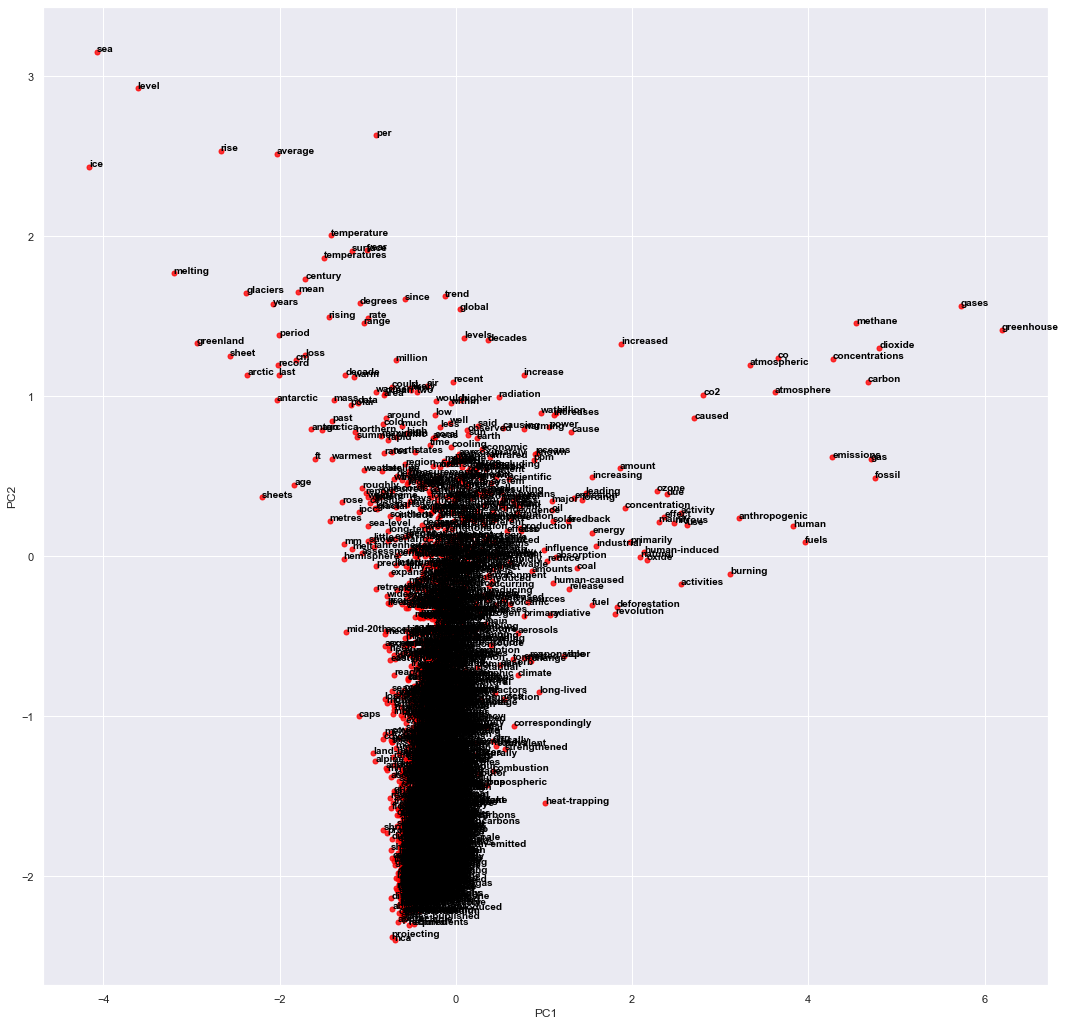

In [15]:
fig = plt.figure(figsize=(18,18))
sns.regplot(data=embedding_df, x="PC1", y="PC2", fit_reg=False, color="red", scatter_kws={'s':25})
 
# add annotations one by one with a loop
for line in range(0,embedding_df.shape[0]):
     plt.text(embedding_df.PC1[line], embedding_df.PC2[line], embedding_df.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.show()

<p>The 2D plot above shows the PCA embeddings of the complete test set. In the center region the plot is crowded with points so it is difficult to interpret. Based on the plot, following similarities were observed:<p>
<ul>
            <li>It can be seen that the upper left side of the graph has word related to ice, polar region and melting of glaciers. However, the upper right of graph has word related to greenhouse, emissions and gases.</li>
            <li>The central and lower bottom of the graph is somewhat related to deforestation , heat-trapping and combustion.</li>
            <li>Top left corner contained similiar words like : greenland, sheet, arctic, antractic, melting.</li>
            <li>Top right corner contained similiar words like : greenhouse, carbon, gases, methane, atmosphere.</li>
            <li>It can be seen that words like greenland and carbon which are very less related are seperate in the graph.</li>
</ul>

### COSINE SIMILARITY FUNCTION FOR PCA EMBEDDING CALCULATIONS

In [16]:
embedding_df.reset_index(level=0, inplace=True)

def cosine_calc(inp):
    score = []
    word_list = []
    for i in range(len(Y)):
        if inp == embedding_df['index'][i]:
                for j in range(len(Y)):
                    cosine_similarity = np.dot(Principal_components_test[i],
                                               Principal_components_test[j])/(np.linalg.norm(Principal_components_test[i])*
                                                                              np.linalg.norm(Principal_components_test[j]))
                    score.append(cosine_similarity)
                    word_list.append(embedding_df['index'][j])
                cosine_scores = pd.DataFrame({'word': word_list, 'cosine_score': score}, columns = ['word','cosine_score'])
                cosine_scores = cosine_scores.sort_values(by=['cosine_score'], ascending=False)
                return cosine_scores.head(10)

<p>A seperate cosine similiarity calculation function is defined to find the 10 most similar word using the PCA embeddings. Based on these calculations, difference in the most similar word are noted in the table below to show the difference in output when compared to Word2Vec embeddings.</p>

### RESULTS FOR MOST SIMILAR WORDS BY WORD2VEC EMBEDDINGS AND PCA EMBEDDINGS

In [17]:
print("Most similar words to degrees")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('degrees'))
print("\nResults by PCA embeddings: " ) 
print(cosine_calc('degrees'))

Most similar words to degrees

Results by Word2vec model: 
[('fahrenheit', 0.99807208776474), ('celsius', 0.9979721307754517), ('mm/yr', 0.9892697930335999), ('occurred', 0.9875884652137756), ('warmer', 0.9875538349151611), ('judge', 0.9840033054351807), ('end', 0.9837105870246887), ('two-thirds', 0.9823581576347351), ('risen', 0.9812933802604675), ('least', 0.9809064865112305)]

Results by PCA embeddings: 
             word  cosine_score
2576      degrees      1.000000
1853    currently      0.999996
2493        could      0.999979
2318  temperature      0.999957
2405       states      0.999893
722          rate      0.999889
2161        range      0.999833
3       generally      0.999796
2821         high      0.999692
680    variations      0.999663


In [18]:
print("Most similar words to greenhouse")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('greenhouse'))
print("\nResults by PCA embeddings: " ) 
print(cosine_calc('greenhouse'))

Most similar words to greenhouse

Results by Word2vec model: 
[('heat-trapping', 0.993493914604187), ('gases', 0.9885135889053345), ('gas', 0.9819725751876831), ('emissions', 0.9774918556213379), ('concentrations', 0.9702357053756714), ('unabated', 0.9684640169143677), ('anthropogenic', 0.9653491973876953), ('ghgs', 0.9641789197921753), ('methane', 0.961546778678894), ('effect', 0.9580555558204651)]

Results by PCA embeddings: 
            word  cosine_score
303   greenhouse      1.000000
2210      carbon      0.999988
1466  production      0.999965
2481        also      0.999883
1130     forcing      0.999849
2047    produced      0.999583
2430       solar      0.999566
838          oil      0.999472
1365  especially      0.999377
1205     leading      0.999356


In [19]:
print("Most similar words to hemisphere")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('hemisphere'))
print("\nResults by PCA embeddings: " ) 
print(cosine_calc('hemisphere'))

Most similar words to hemisphere

Results by Word2vec model: 
[('northern', 0.9938037395477295), ('warm', 0.9900912046432495), ('medieval', 0.9858924150466919), ('data', 0.9849902391433716), ('glacial', 0.9791250824928284), ('satellite', 0.9788761138916016), ('hottest', 0.9784550070762634), ('record', 0.9776619672775269), ('summer', 0.9773421883583069), ('mwp', 0.9767187833786011)]

Results by PCA embeddings: 
              word  cosine_score
728     hemisphere      1.000000
1016         phase      0.999993
1850  observations      0.999852
2171     centuries      0.999789
1116       minimum      0.999777
2003        longer      0.999582
2001    assessment      0.999545
1736     predicted      0.998631
693           melt      0.998593
358    researchers      0.998510


In [20]:
print("Most similar words to antarctica")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('antarctica'))
print("\nResults by PCA embeddings: " ) 
print(cosine_calc('antarctica'))

Most similar words to antarctica

Results by Word2vec model: 
[('mass', 0.9960891604423523), ('loss', 0.9959042072296143), ('land-based', 0.9946593642234802), ('caps', 0.9943209290504456), ('melt', 0.9936200380325317), ('alpine', 0.9936103820800781), ('shelves', 0.9926638603210449), ('shrinkage', 0.9921259880065918), ('extents', 0.9910714626312256), ('antarctic', 0.9909413456916809)]

Results by PCA embeddings: 
            word  cosine_score
1814  antarctica      1.000000
401        every      1.000000
1335    occurred      0.999998
2382   antarctic      0.999997
2969       sheet      0.999994
2732      arctic      0.999993
2406       parts      0.999788
2716      degree      0.999742
2894     weather      0.999693
24     greenland      0.999677


In [21]:
print("Most similar words to greenland")
print("\nResults by Word2vec model: ")
print(model.wv.most_similar('greenland'))
print("\nResults by PCA embeddings: " ) 
print(cosine_calc('greenland'))

Most similar words to greenland

Results by Word2vec model: 
[('sheet', 0.997483491897583), ('sheets', 0.9956241846084595), ('melting', 0.9943464994430542), ('ice', 0.9936538934707642), ('glaciers', 0.9885503053665161), ('antarctic', 0.9871723651885986), ('arctic', 0.9800553917884827), ('caps', 0.9731074571609497), ('loss', 0.965632438659668), ('age', 0.961736261844635)]

Results by PCA embeddings: 
            word  cosine_score
24     greenland      1.000000
2406       parts      0.999988
1272    decrease      0.999921
666      warmest      0.999866
1219     extreme      0.999780
2732      arctic      0.999766
2382   antarctic      0.999737
401        every      0.999694
1814  antarctica      0.999677
1335    occurred      0.999621


<table>
  <tr>
    <th>Word</th>
    <th>Most_similar using Word2Vec (Cosine measure)</th>
    <th>Most_similar using PCA (Cosine measure)</th>
  </tr>
  <tr>
    <td>Degrees</td>
    <td>celsius, fahrenheit, warmer, occurred, mm/yr</td>
    <td>temperatures, rate, range, state, average</td>
   </tr>
  <tr>
    <td>greenhouse</td>
    <td>heat-trapping, gases, emissions, concentrations, dominant</td>
    <td>carbon, solar, oil, climate, economist</td>
   </tr>
  <tr>
    <td>hemisphere</td>
    <td>northern, warm, data, decades, medieval, satellite</td>
    <td>melt, phase, predicted, assessment, researchers</td>
   </tr>
   <tr>
    <td>antarctica</td>
    <td>glaciers, loss, caps, land-based, alpine</td>
    <td>sheet, arctic, antarctica, greenland, weather</td>
   </tr>
   <tr>
    <td>greenland</td>
    <td>sheets, melting, ice, glaciers, antarctic, caps</td>
    <td>decrease, antarctica, parts, antarctic, warmest, dry</td>
   </tr>
</table>

<p>It can be seen that most similar words using PCA embedding are different compared to the embedding of trained Word2Vec model. The information conveyed by Word2Vec embeddings are more appropriate compared to PCA embeddings as the number of dimensions are reduced in PCA that can change the cosine similarity scores among different words. It can also be seen that the information provided by PCA embeddings are correct in many cases though not exactly related to that words.</p>

### PCA EMBEDDING VISUALIZATION FOR MOST SIMILAR WORDS

<p>Using user built functions, we have incorporated a method to represent the most similar word (found using PCA embeddings) and plot it as single colour (in a group), an approach which is similar to plotting 10 nearest neighbors (in out case most similar word found using PCA embedding)<p>
<ul>
            <li>A key of words is decided, whose most similar words are to be plotted.</li>
            <li>Based on the PCA embeddings, most similar words are calculated using the cosine_calc function.</li>
            <li>All the similar embeddings and words are clustered in a single group (in our case using colours).</li>
            <li>Based on the PCA embedding a graph is constructed to represent similar groups based on cosine metric.</li>
            <li>Basically, we have implemented a similar approach to nearest neighbor graph but using cosine similarity as a measurement of distance and plotted most similar words.</li>
</ul>

In [26]:
test_set_pca_df = pd.DataFrame(Principal_components_test, index = common_test, columns = ['PC1','PC2'])
test_set_pca_df.head()

keys = ['greenhouse', 'deforestation', 'arctic', 'industrial', 'energy', 'temperature', 'surface', 'scientific', 'radiation']
pca_similarity_list = [list(cosine_calc(word)['word']) for word in keys]

embedding_clusters = []
word_clusters = []


for similar_list in pca_similarity_list:
    embeddings = []
    words = []
    for word in similar_list:
        words.append(word)
        embeddings.append(list(test_set_pca_df.loc[word][:]))
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
embedding_clusters = np.array(embedding_clusters)

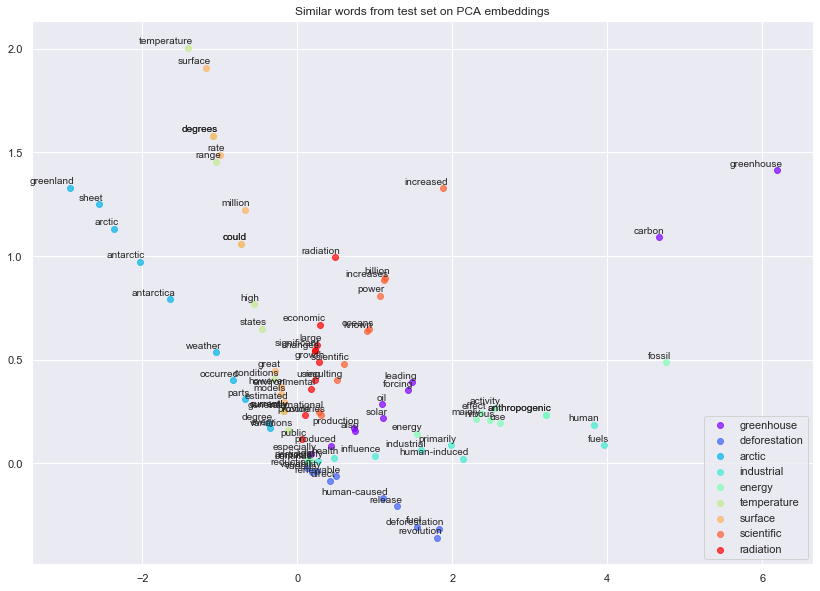

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def pca_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(14, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


pca_plot_similar_words('Similar words from test set on PCA embeddings', keys, embedding_clusters, word_clusters, 0.7,
                        'similar_words.png')

<p>There is a clear seperation between words of same type and having a strong cosine similarity score.</p>
<ul>
            <li>All the vector embeddings start from (0,0) and move away in a single direction based on the classes.</li>
            <li>Since cosine similarity score is computed using vector representation of embeddings, it can be observed that similar score based words are lying very close to each other (approximatly on a single vector) in the vector space.</li>
            <li>Words like carbon, oil, solar are located nearby to greenhouse (denoted using purple) as they have a similar cosine score.</li>
            <li>Words like fossil, anthropogenic are located nearby to energy (denoted using green) as they have a similar cosine score.</li>
            <li>Words like economic, environmental, health are located nearby to radiation (denoted using red) as they have a similar cosine score.</li>
            <li>Words like human-caused, fuel, revolution are located nearby to deforsetation (denoted using dark blue) as they have a similar cosine score.</li>
            <li>Words like human, fossil, fuels are located nearby to industrial (denoted using cyan) as they have a similar cosine score.</li>
            <li>Words like greenland, sheet, antarctic are located nearby to arctic (denoted using blue) as they have a similar cosine score.</li>
            <li>Words like range, high, states are located nearby to temperature (denoted using light green) as they have a similar cosine score.</li>
            <li>Words like degrees, rate, million are located nearby to surface (denoted using light orange) as they have a similar cosine score.</li>
            <li>It can be seen that temperature and surface are very closed place as they have a siginifcant relationship among them based on their similarity. Moreiver, there similar words embedding are also placed very nearby.</li>
</ul>